# Import Data

In [16]:
import numpy as np
import pandas as pd
import os
from dataloader import OCTDataset
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import argparse
import os
import copy
import matplotlib.pyplot as plt


# Get path information
root = os.getcwd()
train = os.path.join(root, "df_prime_train.csv")
test = os.path.join(root, "df_prime_test.csv")



# Label Map
LABELS_SEVERITY = {35: 0,
                   43: 0,
                   47: 1,
                   53: 1,
                   61: 2,
                   65: 2,
                   71: 2,
                   85: 2}


def normalize_array(arr):
    """
    Normalize a 1D NumPy array to have values between 0 and 1.
    """
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    normalized_arr = (arr - arr_min) / (arr_max - arr_min)
    return normalized_arr



'''Obtain Dataset Images (image, label)'''

# experimentally determined mean and std for OCT images
mean = (.1706)
std = (.2112)
normalize = transforms.Normalize(mean=mean, std=std)

# transform matrix
transform2 = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize,
])

args = 'C:/Users/jgril/Documents/GitHub/8803_Final_Project'

# obtain train and test datasets
image_trainset = OCTDataset(args, 'train', transform=transform2)
image_testset = OCTDataset(args, 'test', transform=transform2)


print("loading data")

# obtain flatten training images
images_train = []
labels_train = []


for i in range(len(image_trainset)):
    #flattened training dataset with normalization
    image,label = image_trainset.__getitem__(i)
    my_image = image.flatten().numpy()
    images_train.append(my_image)
    labels_train.append(label)


images_test = []
labels_test = []


for i in range(len(image_testset)):
    #flattened training dataset with normalization
    image,label = image_testset.__getitem__(i)
    my_image = image.flatten().numpy()
    images_test.append(my_image)
    labels_test.append(label)



# convert to numpy array
print("data loaded")
images_train = np.array(images_train)
labels_train = np.array(labels_train)
images_test = np.array(images_test)
labels_test = np.array(labels_test)

loading data
data loaded


# Naive Bayes -- No PCA

In [17]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score


# Load data
X_train = images_train
y_train = labels_train
X_test = images_test
y_test = labels_test


# train a Naive Bayes classifier
clf = GaussianNB()
clf.fit(X_train, y_train)

# evaluate the classifier on the test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test,y_pred)
print('Accuracy:', accuracy)
print("Balanced Accuracy:", balanced_accuracy)

Accuracy: 0.4925503943908852
Balanced Accuracy: 0.4684125014770176


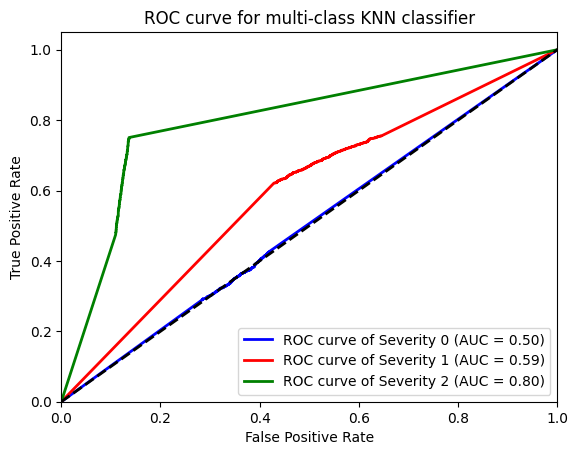

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize


# Calculate the predicted probabilities of each class
y_pred_prob = clf.predict_proba(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute the ROC curve and area under the curve (AUC) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of Severity %d (AUC = %0.2f)' % (i, roc_auc[i]))

# Plot the chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for multi-class Naive Bayes classifier')
plt.legend(loc="lower right")
plt.show()

In [15]:
# metric for recall, precision, and F1 score

from sklearn.metrics import f1_score, recall_score, precision_score
print("Recall: " + str(recall_score(y_test, y_pred, average = None)))
print("Precision: " + str(precision_score(y_test, y_pred, average = None, zero_division = 0)))
print("The F1 score for each class can be represented as such: ")
print(f1_score(y_test, y_pred, average=None))

Recall: [0.29277865 0.62397959 0.48847926]
Precision: [0.32210708 0.58044613 0.50926561]
The F1 score for each class can be represented as such: 
[0.30674342 0.60142611 0.49865591]


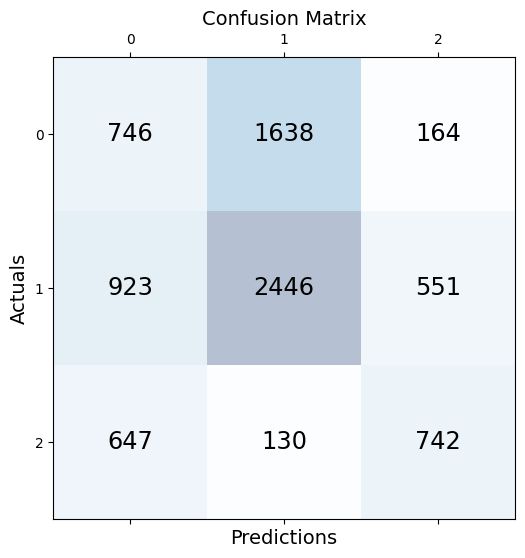

In [16]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## Naive Bayes with PCA n = 10 ~ 500

In [22]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

# Read dataset
X_train = images_train
y_train = labels_train
X_test = images_test
y_test = labels_test

list_balanced_accuracies = []
pca_list = []



for i in range(10, 500, 10):
    #PCA range from 10 to 500 with 10 increments
    n_PCA_components = i
    pca = PCA(n_components=n_PCA_components)
    train_PCA = pca.fit_transform(X_train)
    train_PCA = pca.inverse_transform(train_PCA)
    
    # train a Naive Bayes classifier
    clf = GaussianNB()
    clf.fit(train_PCA, y_train)

    # evaluate the classifier on the test data
    y_pred = clf.predict(X_test)
    balanced_accuracy = balanced_accuracy_score(y_test,y_pred)
    print("Balanced Accuracy:", balanced_accuracy)
    print()

    list_balanced_accuracies.append(balanced_accuracy)
    pca_list.append(i)

Balanced Accuracy: 0.40816474232372846

Balanced Accuracy: 0.4500911530865448

Balanced Accuracy: 0.5138212977498692

Balanced Accuracy: 0.5116737141506728

Balanced Accuracy: 0.4991538799142486

Balanced Accuracy: 0.49197346432369476

Balanced Accuracy: 0.49655791597035837

Balanced Accuracy: 0.5019937627656522

Balanced Accuracy: 0.5005884860147533

Balanced Accuracy: 0.49866477608413096

Balanced Accuracy: 0.49907222194088546

Balanced Accuracy: 0.49808325315237756

Balanced Accuracy: 0.49722215188805047

Balanced Accuracy: 0.49813199473337716

Balanced Accuracy: 0.49712994378893

Balanced Accuracy: 0.4953060380479735

Balanced Accuracy: 0.4951104387164295

Balanced Accuracy: 0.49289111426208204

Balanced Accuracy: 0.492433871811752

Balanced Accuracy: 0.4914389949528199

Balanced Accuracy: 0.4914455360307895

Balanced Accuracy: 0.4920217838996641

Balanced Accuracy: 0.4909353319491568

Balanced Accuracy: 0.49081463851049106

Balanced Accuracy: 0.4892494218531085

Balanced Accuracy:

In [ ]:
# Balanced Accuracy vs n_components for PCA
plt.plot(pca_list, list_balanced_accuracies)
plt.xlabel('PCA components')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs PCA Components')

bestPCA = np.argmax(list_balanced_accuracies)
print("Best PCA Components Values: ", pca_list[bestPCA])
print("Balanced Accuracy: ", list_balanced_accuracies[bestPCA])

## Naive Bayes with PCA on best n_components

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

X_train = images_train
y_train = labels_train
X_test = images_test
y_test = labels_test


bestN = np.argmax(list_balanced_accuracies)
print(bestN)

#best PCA
n_PCA_components = pca_list[bestN]
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(X_train)
train_PCA = pca.inverse_transform(train_PCA)

# train a Naive Bayes classifier
clf = GaussianNB()
clf.fit(train_PCA, y_train)

# evaluate the classifier on the test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test,y_pred)
print("Balanced Accuracy:", balanced_accuracy)
print()



Balanced Accuracy: 0.5140930689893823



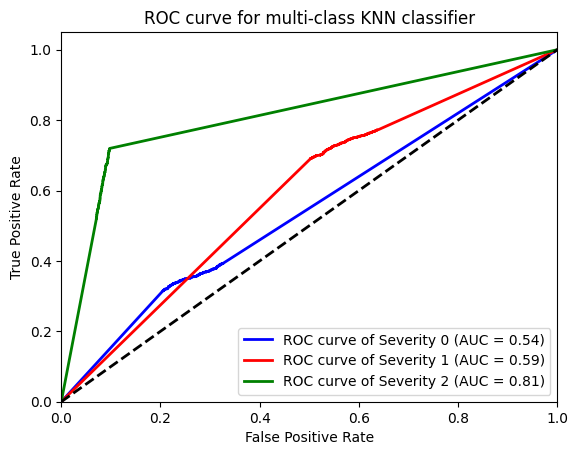

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize


# Calculate the predicted probabilities of each class
y_pred_prob = clf.predict_proba(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute the ROC curve and area under the curve (AUC) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of Severity %d (AUC = %0.2f)' % (i, roc_auc[i]))

# Plot the chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for multi-class Naive Bayes classifier')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# metric for recall, precision, and F1 score

from sklearn.metrics import f1_score, recall_score, precision_score
print("Recall: " + str(recall_score(y_test, y_pred, average = None)))
print("Precision: " + str(precision_score(y_test, y_pred, average = None, zero_division = 0)))
print("The F1 score for each class can be represented as such: ")
print(f1_score(y_test, y_pred, average=None))

Recall: [0.31789639 0.69311224 0.53127057]
Precision: [0.41731066 0.56900524 0.63493312]
The F1 score for each class can be represented as such: 
[0.36088216 0.62495687 0.57849462]


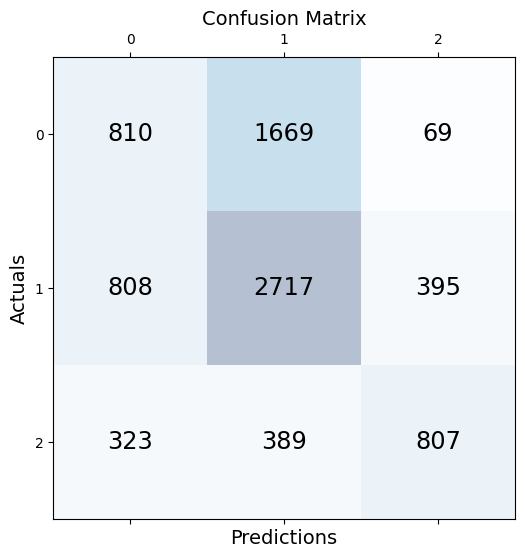

In [ ]:
# confusion metric

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('Actuals', fontsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.show()